In [1]:
import gc
import glob
import math
import os
import random
import re
import sys
import time

import cv2
import matplotlib
import matplotlib.pyplot as plt
import model as modellib
import numpy as np
import pandas as pd
import utils
import visualize
from config import Config
from model import log
from skimage.io import concatenate_images, imread, imread_collection, imshow
from skimage.transform import resize
from tqdm import tqdm
from utils_wr import *
from sklearn.utils import shuffle

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)


ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco_4ch.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/w/anaconda3/envs/idp3exp/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
class GISSConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "giss_depth1"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 6

    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024
    IMAGE_CHANNELS = 4
    IMAGE_PADDING = True
    
    # The strides of each layer of the FPN Pyramid. These values
    # are based on a Resnet101 backbone.
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 128
    
    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Non-max suppression threshold to filter RPN proposals.
    # You can reduce this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7
    
    # Max number of final detections
    DETECTION_MAX_INSTANCES = 128
    
    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3
    
    # Learning rate and momentum
    # The Mask RCNN paper uses lr=0.02, but on TensorFlow it causes
    # weights to explode. Likely due to differences in optimzer
    # implementation.
    LEARNING_RATE = 0.001
    LEARNING_MOMENTUM = 0.9

    # Weight decay regularization
    WEIGHT_DECAY = 0.0001

    # Use RPN ROIs or externally generated ROIs for training
    # Keep this True for most situations. Set to False if you want to train
    # the head branches on ROI generated by code rather than the ROIs from
    # the RPN. For example, to debug the classifier head without having to
    # train the RPN.
    USE_RPN_ROIS = True
    
    MEAN_PIXEL = np.array([123.7, 116.8, 103.9, 0.])
    
    STEPS_PER_EPOCH = 26
    VALIDATION_STEPS = 7

In [3]:
class GISSDataset(utils.Dataset):

    def load_data(self, X, y, ids, shapes, classes):

        self.add_class("giss_depth1", 1, "car")
        self.add_class("giss_depth1", 2, "building")
        self.add_class("giss_depth1", 3, "human")
        self.add_class("giss_depth1", 4, "truck")
        self.add_class("giss_depth1", 5, "container")
        self.add_class("giss_depth1", 6, "winter-car")

        src = '/home/w/Projects/PW-GISS/input/GISS/Datasets/images/'
        
        for i in range(len(ids)):
            path = src + ids[i]
            img_path = path + '/images/' + ids[i]
            self.add_image("giss_depth1", image_id=ids[i], path=img_path,
                           image=X[i], mask=y[i], classes=classes[i],
                           shape=shapes[i])
        
    def load_image(self, image_id):
        info = self.image_info[image_id]
        return info['image']

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        class_ids = np.asarray(info['classes'])
        return info['mask'], class_ids.astype(np.int32)
    

def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax

    
def get_data(src, mode='train'):
    X = pd.read_pickle(src + 'img_{}.pkl'.format(mode))
    y = pd.read_pickle(src + 'msk_{}.pkl'.format(mode))
    filenames = pd.read_pickle(src + 'names_{}.pkl'.format(mode))
    shapes = pd.read_pickle(src + 'shapes_{}.pkl'.format(mode))
    classes = pd.read_pickle(src + 'classes_{}.pkl'.format(mode))
    return X, y, filenames, shapes, classes


def resize_pad(X, y=None):
    
    X_ = np.zeros((len(X), 1024, 1024, X[0].shape[-1]))
    y_ = []
    
    for i in range(len(X)):
        image, window, scale, padding = utils.resize_image(
            X[i], 
            min_dim=config.IMAGE_MIN_DIM, 
            max_dim=config.IMAGE_MAX_DIM,
            padding=config.IMAGE_PADDING)
        X_[i] = image
        if y is not None:
            mask = utils.resize_mask(y[i], scale, padding)
            y_.append(mask)
        
    if y is not None:
        return X_, y_
    else:
        return X_
    
    
def subset_depth_data(src_depth, X, y, train_filenames, train_shapes, train_classes, add_depth_map=False):

    filenames_depth = pd.Series(glob.glob(src_depth + '*.png'))
    train_filenames = pd.Series(train_filenames)
    print('Number of images with depth maps: {}'.format(len(filenames_depth)))
    
    imgnames_depth = filenames_depth.apply(lambda x: x.split('/')[-1].replace('_depth', '').replace('.png', '.JPG'))
    imgnames_intersect = np.intersect1d(train_filenames, imgnames_depth)
    imgnames_intersect_index = train_filenames[train_filenames.isin(imgnames_depth)].index.astype(int).tolist()
    print('Number of intersecting images with depth maps: {}'.format(len(imgnames_intersect)))
    
    filenames_depth_intersect = pd.Series(imgnames_intersect).apply(
        lambda x: src_depth + (x.replace('.', '_depth.').replace('.JPG', '.png')))

    X_depth = np.take(X, imgnames_intersect_index, axis=0)
    y_depth = np.take(y, imgnames_intersect_index, axis=0)
    shapes_depth = np.take(np.asarray(train_shapes), imgnames_intersect_index, axis=0)
    classes_depth = np.take(np.asarray(train_classes), imgnames_intersect_index, axis=0)
    print('Number of images after taking intersect: {}'.format(len(X_depth)))
    
    X_depth_resized = []
    
    j = 0
    for i in imgnames_intersect_index:
        print('\nPreparing image: {}, index: {}'.format(imgnames_intersect[j], j))
        img_depth = imread(filenames_depth_intersect[j])
        
        if img_depth.shape[0] != X[i].shape[0] or img_depth.shape[1] != X[i].shape[1]:
            print('Resizing image to: {}'.format(X[i].shape))
            img_depth = resize(img_depth, (X[i].shape[0], X[i].shape[1]), preserve_range=True)
            
        img_depth = np.expand_dims(img_depth, axis=-1)
        if add_depth_map:
            X_depth_full = np.dstack([X_depth[j], img_depth])
            X_depth_resized.append(X_depth_full)
            assert X_depth_full.shape[0] == y_depth[j].shape[0]
            assert X_depth_full.shape[1] == y_depth[j].shape[1]
            print('Original image shape: {}'.format(X_depth[j].shape))
            print('Depth map shape: {}'.format(img_depth.shape))
            print('Final image shape: {}\n'.format(X_depth_full.shape))
        else:
            X_depth_resized.append(X_depth[j])
            assert X_depth[j].shape[0] == y_depth[j].shape[0]
            assert X_depth[j].shape[1] == y_depth[j].shape[1]
            print('Original image shape: {}'.format(X_depth[j].shape))
            print('Depth map shape: {}'.format(img_depth.shape))
        j += 1
    
    print('Final number of images: {}'.format(len(X_depth_resized)))
    assert len(X_depth_resized) == len(y_depth) == len(imgnames_intersect) == len(shapes_depth) == len(classes_depth)
    
    return X_depth_resized, y_depth, imgnames_intersect, shapes_depth, classes_depth

In [4]:
src_path = '/home/w/Projects/PW-GISS/data/DetectorSet2/'
src_depth = '/home/w/Projects/PW-GISS/input/90oblot_depth/'

load_test = True
use_depth = True

config = GISSConfig()
config.display()


if load_test:
    X_test, y_test, test_filenames, test_shapes, test_classes = get_data(
        src_path, mode='test')

    X_d, y_d, test_filenames, test_shapes, test_classes = subset_depth_data(
        src_depth, X_test, y_test, test_filenames, test_shapes,
        test_classes, add_depth_map=use_depth)
    X_test_, y_test_ = resize_pad(X_d, y_d)

    dataset_test = GISSDataset()
    dataset_test.load_data(
        X_test_, y_test_, test_filenames, test_shapes, test_classes)
    dataset_test.prepare()

    print('Number of test images : {}'.format(len(dataset_test.image_info)))

    del X_test, y_test
    del X_test_, y_test_
    gc.collect()

else:
    X, y, train_filenames, train_shapes, train_classes = get_data(src_path)
    X_d, y_d, train_filenames, train_shapes, train_classes = subset_depth_data(
        src_depth, X, y,
        train_filenames, train_shapes,
        train_classes, add_depth_map=use_depth)
    X_, y_ = resize_pad(X_d, y_d)

    subset_border = int(len(X_) * 0.8)

    X_tr = X_[:subset_border]
    y_tr = y_[:subset_border]
    tr_ids = train_filenames[:subset_border]
    tr_shapes = train_shapes[:subset_border]
    tr_classes = train_classes[:subset_border]

    X_val = X_[subset_border:]
    y_val = y_[subset_border:]
    val_ids = train_filenames[subset_border:]
    val_shapes = train_shapes[subset_border:]
    val_classes = train_classes[subset_border:]

    dataset_train = GISSDataset()
    dataset_train.load_data(X_tr, y_tr, tr_ids, tr_shapes, tr_classes)
    dataset_train.prepare()

    dataset_val = GISSDataset()
    dataset_val.load_data(X_val, y_val, val_ids, val_shapes, val_classes)
    dataset_val.prepare()

    print('Number of training images : {}'.format(
        len(dataset_train.image_info)))
    print('Number of validation images : {}'.format(len(dataset_val.image_info)))

    del X_, y_, X, y
    del X_tr, y_tr, X_val, y_val
    gc.collect()



Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        128
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_CHANNELS                 4
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  1024
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    4]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9   0. ]
MINI_MASK_SHAPE                (56, 56)
NAME                           giss_depth1
NUM_CLASSES                    7
POOL_SIZE                      7
POST_NMS_ROIS_INF

/home/w/anaconda3/envs/idp3exp/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Resizing image to: (768, 1024, 3)
Original image shape: (768, 1024, 3)
Depth map shape: (768, 1024, 1)
Final image shape: (768, 1024, 4)


Preparing image: DJI_0029.JPG, index: 2
Resizing image to: (768, 1024, 3)
Original image shape: (768, 1024, 3)
Depth map shape: (768, 1024, 1)
Final image shape: (768, 1024, 4)


Preparing image: DJI_0037.JPG, index: 3
Resizing image to: (768, 1024, 3)
Original image shape: (768, 1024, 3)
Depth map shape: (768, 1024, 1)
Final image shape: (768, 1024, 4)


Preparing image: DJI_0061.JPG, index: 4
Resizing image to: (768, 1024, 3)
Original image shape: (768, 1024, 3)
Depth map shape: (768, 1024, 1)
Final image shape: (768, 1024, 4)


Preparing image: DJI_0075.JPG, index: 5
Resizing image to: (768, 1024, 3)
Original image shape: (768, 1024, 3)
Depth map shape: (768, 1024, 1)
Final image shape: (768, 1024, 4)

Final number of images: 6
Number of test images : 6


Image objects classes: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Image and mask shapes: (1024, 1024, 4), (1024, 1024, 15)
Mask min and max: 0, 1
Image min and max: 0, 254


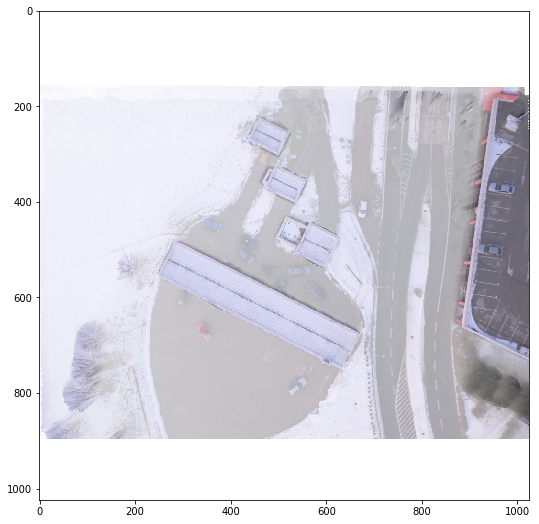

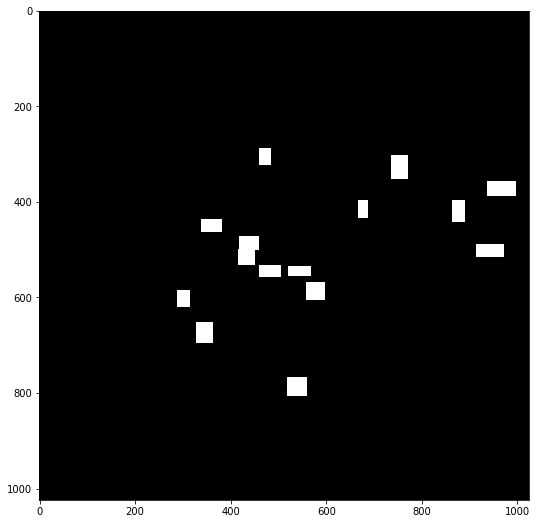

In [5]:
plt.rcParams['figure.figsize'] = (12, 9)


check_valid = True

if check_valid:
    dataset = dataset_val
else:
    dataset = dataset_train
    

random_ind = np.random.randint(0, len(dataset.image_info))

img_vis = dataset.image_info[random_ind]['image'].astype(int)
mask_vis = dataset.image_info[random_ind]['mask']
class_vis = dataset.image_info[random_ind]['classes']


random_ind2 = np.random.randint(0, mask_vis.shape[-1])

print('Image objects classes: {}'.format(class_vis))
print('Image and mask shapes: {}, {}'.format(img_vis.shape, mask_vis.shape))
print('Mask min and max: {}, {}'.format(mask_vis.min(), mask_vis.max()))
print('Image min and max: {}, {}'.format(img_vis.min(), img_vis.max()))

plt.imshow(img_vis)
plt.show()
plt.imshow(np.max(mask_vis, axis=-1), cmap='gray')
plt.show()

## Create Model

In [6]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [7]:
init_with = "coco"  # imagenet, coco, or last

weights_src = '/home/w/Projects/PW-GISS/scripts/Mask_RCNN/logs/giss20180313T1639/'
weights_file = weights_src + 'coco_4ch.h5'


if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    model.load_weights(weights_file, by_name=True)

In [8]:
train_heads = True


if train_heads:
    model.train(dataset_train, dataset_val, 
                learning_rate=config.LEARNING_RATE, 
                epochs=10, 
                layers='heads')


model.train(dataset_train, dataset_val, 
        learning_rate=config.LEARNING_RATE,
        epochs=20, 
        layers="all")

Instructions for updating:
Use the retry module or similar alternatives.

Starting at epoch 0. LR=0.001

Checkpoint Path: /home/w/Projects/PW-GISS/scripts/Mask_RCNN/logs/giss_depth120180319T1114/mask_rcnn_giss_depth1_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeD

/home/w/anaconda3/envs/idp3exp/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/w/anaconda3/envs/idp3exp/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
/home/w/anaconda3/envs/idp3exp/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/w/anaconda3/envs/idp3exp/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Usi

Epoch 1/10
26/26 [==============================] - 23s 900ms/step - loss: 2.9850 - rpn_class_loss: 0.2021 - rpn_bbox_loss: 0.7733 - mrcnn_class_loss: 1.0139 - mrcnn_bbox_loss: 0.8056 - mrcnn_mask_loss: 0.1901 - val_loss: 1.6598 - val_rpn_class_loss: 0.0683 - val_rpn_bbox_loss: 0.3478 - val_mrcnn_class_loss: 0.6579 - val_mrcnn_bbox_loss: 0.5020 - val_mrcnn_mask_loss: 0.0838
Epoch 2/10
26/26 [==============================] - 12s 449ms/step - loss: 1.4440 - rpn_class_loss: 0.0831 - rpn_bbox_loss: 0.3130 - mrcnn_class_loss: 0.6393 - mrcnn_bbox_loss: 0.3924 - mrcnn_mask_loss: 0.0161 - val_loss: 1.2468 - val_rpn_class_loss: 0.0467 - val_rpn_bbox_loss: 0.2966 - val_mrcnn_class_loss: 0.5705 - val_mrcnn_bbox_loss: 0.3312 - val_mrcnn_mask_loss: 0.0019
Epoch 3/10
26/26 [==============================] - 12s 462ms/step - loss: 1.1533 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 0.2528 - mrcnn_class_loss: 0.5307 - mrcnn_bbox_loss: 0.3099 - mrcnn_mask_loss: 0.0014 - val_loss: 0.9644 - val_rpn_class_l

Epoch 11/20
26/26 [==============================] - 42s 2s/step - loss: 0.5608 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.1467 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.1478 - mrcnn_mask_loss: 4.0366e-04 - val_loss: 0.7386 - val_rpn_class_loss: 0.0171 - val_rpn_bbox_loss: 0.3163 - val_mrcnn_class_loss: 0.2117 - val_mrcnn_bbox_loss: 0.1933 - val_mrcnn_mask_loss: 1.5256e-04
Epoch 12/20
26/26 [==============================] - 19s 743ms/step - loss: 0.5404 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1368 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.1439 - mrcnn_mask_loss: 2.7230e-04 - val_loss: 0.6443 - val_rpn_class_loss: 0.0133 - val_rpn_bbox_loss: 0.2513 - val_mrcnn_class_loss: 0.2120 - val_mrcnn_bbox_loss: 0.1675 - val_mrcnn_mask_loss: 1.4458e-04
Epoch 13/20
26/26 [==============================] - 19s 745ms/step - loss: 0.4695 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2058 - mrcnn_bbox_loss: 0.1358 - mrcnn_mask_loss: 3.0896e-04 - val_loss: 0.57

## 10 epochs heads + 10 epochs all (COCO weights):

- No depth map:

    Epoch 10/10
    26/26 [==============================] - 18s 709ms/step - loss: 0.4457 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0971 - mrcnn_class_loss: 0.2022 - mrcnn_bbox_loss: 0.1378 - mrcnn_mask_loss: 3.8990e-04 - val_loss: 0.3900 - val_rpn_class_loss: 0.0026 - val_rpn_bbox_loss: 0.1491 - val_mrcnn_class_loss: 0.0992 - val_mrcnn_bbox_loss: 0.1390 - val_mrcnn_mask_loss: 5.9865e-05

## Detection

In [5]:
class InferenceConfig(GISSConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


if load_test:
    dataset = dataset_test
else:
    dataset = dataset_val

Loading weights from  /home/w/Projects/PW-GISS/scripts/Mask_RCNN/logs/giss_depth120180319T1114/mask_rcnn_giss_depth1_0020.h5


image id: 5

image id: 5
original_image           shape: (1024, 1024, 4)       min:    0.00000  max:  251.25000
image_meta               shape: (15,)                 min:    0.00000  max: 1024.00000
gt_class_id              shape: (8,)                  min:    1.00000  max:    6.00000
gt_bbox                  shape: (8, 4)                min:   48.00000  max: 1015.00000
gt_mask                  shape: (1024, 1024, 8)       min:    0.00000  max:    1.00000
Processing 1 images
image                    shape: (1024, 1024, 4)       min:    0.00000  max:  251.25000
molded_images            shape: (1, 1024, 1024, 4)    min: -123.70000  max:  251.25000
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000


/home/w/anaconda3/envs/idp3exp/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/w/anaconda3/envs/idp3exp/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Time it took for inference: 0.27144551277160645


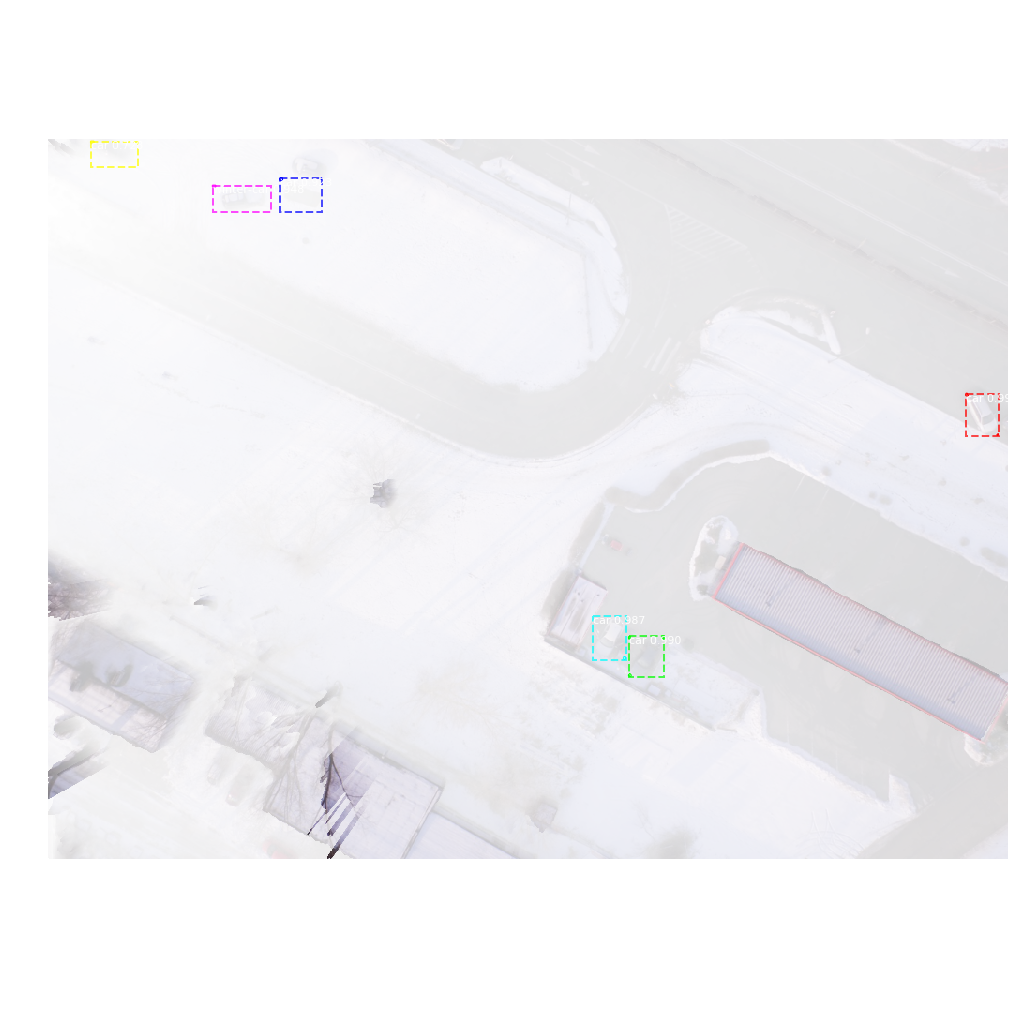

In [13]:
# image_id = random.choice(dataset.image_ids)
image_id = 5

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, inference_config, 
                           image_id, use_mini_mask=False)

print('image id:', image_id)
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


t_start = time.time()
results = model.detect([original_image], verbose=1)
t_end = time.time()
print('Time it took for inference: {}'.format(t_end - t_start))


r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=get_ax(size=18),
                           figsize=(14, 14))

In [11]:
from matplotlib import patches
import colorsys


# from Mask R-CNN
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def get_center(x):
    x['x'] = x.xmax - x.xmin
    x['y'] = x.ymax - x.ymin
    return x


def show_bbs(df, image, image_name):

    df_image = df[df.filename == image_name]

    fig, ax = plt.subplots()
    ax.imshow(image)
    colors = random_colors(df_image.shape[0])
    
    for i in range(df_image.shape[0]):
        color = colors[i]
        ax.add_patch(patches.Rectangle((df_image.iloc[i, :]['xmin'],
                                        df_image.iloc[i, :]['ymin']),
                                       df_image.iloc[i, :]['x'],
                                       df_image.iloc[i, :]['y'], linewidth=2,
                                       alpha=0.7, linestyle="dashed",
                                       edgecolor=color, facecolor='none'))

    return


def show_bbs2(image, mask):
    
    m2 = np.zeros((mask.shape[0], mask.shape[1]))
    
    for i in range(mask.shape[-1]):
        m2 = np.maximum(m2, mask[:, :, i])
        
    plt.imshow(image)
    plt.show()
    plt.imshow(m2, cmap='gray')
    plt.show()
    return


def create_predictions_df(dataset):
    
    df_full = pd.DataFrame()
    
    for image_id in dataset.image_ids:
    
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, inference_config, 
                               image_id, use_mini_mask=False)

        print('image id:', image_id)
        t_start = time.time()
        results = model.detect([original_image], verbose=1)
        t_end = time.time()
        print('Time it took for inference: {}'.format(t_end - t_start))

        r = results[0]

        df_bb = pd.DataFrame(r['rois'])
        df_bb.columns = ['ymin', 'xmin', 'ymax', 'xmax']
        df_bb['filename'] = dataset.image_info[image_id]['id']
        df_bb['class'] = r['class_ids']
        df_bb['confidence'] = r['scores']
        df_bb = df_bb.apply(lambda x: get_center(x), axis=1)
        
        df_full = pd.concat([df_full, df_bb])
        
    df_full.reset_index(inplace=True, drop=True)
        
    return df_full

## Evaluation